<font size=7>Own scan path and individual preference for saliency features and object categories<font>

<font size=5>Step 1:<font>

<font size=3> Run all cells of Step 1. Using the **Subject** dropdown menu, select your own subject number, then go through the 40 images you viewed in the lab during the experiment to see your own scanpaths.

<font size=3>*Note: Fixations are represented by circles. Circle size is proportional to fixation duration and circle color indicates the order of the fixation (first = lightest, last = darkest).*

<font size=3>•	Compare your scanpath with the predictions of the saliency model and the object categories from tasks D and E.

<font size=3>•	Can you recognize an individual preference?

In [1]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.io
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
import ipywidgets as widgets
from IPython.display import display, HTML
from PIL import Image
import cv2
import ITTISaliencyLib
import warnings

warnings.filterwarnings('ignore')

im_width, im_height = 800, 600
im_width_real, im_height_real = 1146, 876  # real size
exp_scale_width = im_width_real / im_width  # 1.4325
exp_scale_height = im_height_real / im_height  # 1.46

current_dir = os.getcwd()
print(current_dir)
# Path to the folder containing JPG images
#IMAGE_FOLDER = '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/images_task_F'
IMAGE_FOLDER = 'images_task_F'
RESULTS_FOLDER_FIX ='data_task_C/data_fix/'
RESULTS_FOLDER_SACC ='data_task_C/data_sacc/'
#RESULTS_FOLDER_FIX ='/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/data_task_C/data_fix/'
#RESULTS_FOLDER_SACC ='/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/data_task_C/data_sacc/'
#SALIENCY_MAP_DICT = 'data_task_F/saliency_map_dict.npy'
#RESULTS_FOLDER = '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/pilot_res'
#OSIE_DATA = '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/data_task_F/attrs_OSIE_40.mat'
OSIE_DATA = 'data_task_F/attrs_OSIE_40.mat'

# Get a list of JPG image files in the folder
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')]
subject_list = [sub[:2] for sub in os.listdir(RESULTS_FOLDER_FIX)if sub != '.DS_Store']
print(subject_list)
#subject_list = ['zt', 'pp']

/var/folders/8l/8mhtfcfd3kx35x8ns523w5zm0000gn/T/ipykernel_70448/1445202563.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter
['zt', 'jp', 'pp']


***The cell below might take a long time to execacute***

In [5]:
def make_saliency_map_dict():
    #images_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/images"
    #image_list = []

    #os.chdir(images_path)
    #os.chdir(IMAGE_FOLDER)
    #for file in glob.glob("*.jpg"):
    #    image_list.append(file)

    saliency_map_dict = {}

    #for image_name in image_list:
    for image_name in image_files:
        img = cv2.imread(os.path.join(IMAGE_FOLDER,image_name))
        saliency_map_dict[image_name] = {}

        # image_num = image_name[0:4]
        # initialize
        # imgsize = img.shape
        # img_width = imgsize[1]
        # img_height = imgsize[0]
        # sm = pySaliencyMap.pySaliencyMap(img_width, img_height)
        # computation of saliency maps
        saliency_map = ITTISaliencyLib.get_spatial_saliency_map(img)
        saliency_map_intensity = ITTISaliencyLib.get_spatial_saliency_map_I(img)
        saliency_map_color = ITTISaliencyLib.get_spatial_saliency_map_C(img)
        saliency_map_orientation = ITTISaliencyLib.get_spatial_saliency_map_O(img)

        list_of_maps = [
            ("saliency_map", saliency_map),
            ("saliency_map_intensity", saliency_map_intensity),
            ("saliency_map_color", saliency_map_color),
            ("saliency_map_orientation", saliency_map_orientation),
        ]

        saliency_map_dict[image_name].update(list_of_maps)

    return saliency_map_dict

SALIENCY_MAP_DICT = make_saliency_map_dict()

In [6]:
def extract_semantic_fix(subject_num):
    # Add necessary path
    #fix_data_path = (
    #    "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
    #    + subject_num
    #    + "_fix_data.csv"
    #)
    fix_data_path = (
        RESULTS_FOLDER_FIX
        + subject_num
        + "_fix_data.csv"
    )

    OSIE_data_path = OSIE_DATA
    #"/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/attrs_OSIE_40.mat"

    # Load the MATLAB .mat file containing the data
    fix_data = pd.read_csv(fix_data_path, sep=",")
    # mat_data = loadmat(OSIE_data_path)
    mat_dict = loadmat(OSIE_data_path, simplify_cells=True)
    # df = pd.read_table("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc")
    # ascii_grid = np.loadtxt("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc", skiprows=100)
    attrs_OSIE_40 = mat_dict["attrs_OSIE_40"]

    # Constants and parameters
    dims = [0, 1, 5, 7, 10]
    # Header = ["Text", "Face", "Taste", "Motion", "Touched"]

    im_width, im_height = 800, 600

    im_width_real, im_height_real = 1146, 876  # real size
    exp_scale_width = im_width_real / im_width  # 1.4325
    exp_scale_height = im_height_real / im_height  # 1.46
    screen_width, screen_height = 1920, 1080
    # screen_x_cm, screen_y_cm, vp_dist_cm = 51.5, 29.0, 60
    # sample_freq = 1000
    # XPIX2DEG = np.arctan((screen_x_cm / screen_width) / vp_dist_cm) * (180 / np.pi)
    # YPIX2DEG = np.arctan((screen_y_cm / screen_height) / vp_dist_cm) * (180 / np.pi)
    # folder_name = f"e1v{subject_num}b1"
    fixations = {}

    # im_num = '1001.jpg'
    # block_num = 1

    BLOCK_NUMS = 40
    for block_num in range(0, BLOCK_NUMS):
        # block_num = 1
        image_name = attrs_OSIE_40[block_num]["img"]
        # objs = attrs_OSIE_40[block_num]["objs"]

        fix_data_block = fix_data[fix_data["img"] == image_name]
        Cfix = len(fix_data_block)  # fixation count
        Dfix = list(fix_data_block["dur"])  # fixation durations
        Xfix = list(
            ((fix_data_block["axp"] - (screen_width / 2)) / exp_scale_width) + (im_width / 2)
        )
        Order = list(fix_data_block["fix_order"])
        # Xfix = Xfix - (screen_width/2) #/ exp_scale_width)
        # Xfix = Xfix + (im_width/2)
        # Xfix_norm = Xfix/exp_scale_width # X coord
        Yfix = list(
            ((fix_data_block["ayp"] - (screen_height / 2)) / exp_scale_height) + (im_height / 2)
        )  # / exp_scale_height)  # Y coord
        # for im_num in pd.unique(fix_data['img']):
        # Analyze semantic content
        sem = np.zeros((Cfix, len(dims)))

        for d in range(len(dims)):
            map_sum = np.zeros((im_height, im_width))
            # map_ori = []
            for obj in range(len(attrs_OSIE_40[block_num]["objs"])):
                # obj = 0
                if attrs_OSIE_40[block_num]["objs"][obj]["features"][dims[d]] > 0:
                    # print(attrs_OSIE_40[block_num-1]['objs'][obj]['features'][dims[d]])
                    map_ori = attrs_OSIE_40[block_num]["objs"][obj]["map"]
                    # print(map_ori)
                    map_sum += map_ori
                    # print(map_sum)
            for f in range(Cfix):
                sem[f, d] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    sem[f, d] = map_sum[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]

        fixations[image_name] = {
            "X": Xfix,
            "Y": Yfix,
            # "Onset": Tfix,
            "Duration": Dfix,
            # "Amplitude": Asac,
            "Sem": pd.DataFrame(sem),
            "Order": Order
            # "Sal": sal,
        }

    return fixations



def extract_semantic_saliency_fix(subject_num):
    # Add necessary path
    fix_data_path = (
        RESULTS_FOLDER_FIX
        + subject_num
        + "_fix_data.csv"
    )

    OSIE_data_path = OSIE_DATA

    #saliency_map_path = SALIENCY_MAP_DICT

    # Load the MATLAB .mat file containing the data
    fix_data = pd.read_csv(fix_data_path, sep=",")
    # mat_data = loadmat(OSIE_data_path)
    mat_dict = loadmat(OSIE_data_path, simplify_cells=True)
    attrs_OSIE_40 = mat_dict["attrs_OSIE_40"]
    #saliency_map_dict = np.load(
    #    saliency_map_path,
    #    allow_pickle="TRUE",
    #).item()
    saliency_map_dict = SALIENCY_MAP_DICT
    
    # print(saliency_map_dict)
    # df = pd.read_table("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc")
    # ascii_grid = np.loadtxt("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc", skiprows=100)

    # Constants and parameters
    dims = [0, 1, 5, 7, 10]
    # Header = ["Text", "Face", "Taste", "Motion", "Touched"]

    im_width, im_height = 800, 600

    im_width_real, im_height_real = 1146, 876  # real size
    exp_scale_width = im_width_real / im_width  # 1.4325
    exp_scale_height = im_height_real / im_height  # 1.46
    screen_width, screen_height = 1920, 1080
    # screen_x_cm, screen_y_cm, vp_dist_cm = 51.5, 29.0, 60
    # sample_freq = 1000
    # XPIX2DEG = np.arctan((screen_x_cm / screen_width) / vp_dist_cm) * (180 / np.pi)
    # YPIX2DEG = np.arctan((screen_y_cm / screen_height) / vp_dist_cm) * (180 / np.pi)
    # folder_name = f"e1v{subject_num}b1"
    fixations = {}

    # im_num = '1001.jpg'
    # block_num = 1

    BLOCK_NUMS = 40
    for block_num in range(0, BLOCK_NUMS):
        # block_num = 1
        image_name = attrs_OSIE_40[block_num]["img"]
        # objs = attrs_OSIE_40[block_num]["objs"]

        fix_data_block = fix_data[fix_data["img"] == image_name]
        Cfix = len(fix_data_block)  # fixation count
        Dfix = list(fix_data_block["dur"])  # fixation durations
        Xfix = list(
            ((fix_data_block["axp"] - (screen_width / 2)) / exp_scale_width) + (im_width / 2)
        )
        # Xfix = Xfix - (screen_width/2) #/ exp_scale_width)
        # Xfix = Xfix + (im_width/2)
        # Xfix_norm = Xfix/exp_scale_width # X coord
        Yfix = list(
            ((fix_data_block["ayp"] - (screen_height / 2)) / exp_scale_height) + (im_height / 2)
        )  # / exp_scale_height)  # Y coord
        Order = list(fix_data_block["fix_order"])
        # for im_num in pd.unique(fix_data['img']):

        # Analyze semantic content
        sem = np.zeros((Cfix, len(dims)))

        for d in range(len(dims)):
            map_sum = np.zeros((im_height, im_width))
            # map_ori = []
            for obj in range(len(attrs_OSIE_40[block_num]["objs"])):
                # obj = 0
                if attrs_OSIE_40[block_num]["objs"][obj]["features"][dims[d]] > 0:
                    # print(attrs_OSIE_40[block_num-1]['objs'][obj]['features'][dims[d]])
                    map_ori = attrs_OSIE_40[block_num]["objs"][obj]["map"]
                    # print(map_ori)
                    map_sum += map_ori
                    # print(map_sum)
            for f in range(Cfix):
                sem[f, d] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    sem[f, d] = map_sum[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]

        sem_df = pd.DataFrame(sem)

        # Analyze saliency content
        sal = np.zeros((Cfix, len(saliency_map_dict[image_name])))
        list_of_sal_maps = list(saliency_map_dict[image_name].keys())

        for i, sal_map in enumerate(list_of_sal_maps):
            # print(i, sal_map)
            sal_map_ori = saliency_map_dict[image_name][sal_map]

            for f in range(Cfix):
                sal[f, i] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    # sal[f, i] = sal_map_ori[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]
                    sal[f, i] = (
                        np.sum(sal_map_ori < sal_map_ori[int(round(Yfix[f])), int(round(Xfix[f]))])
                        / sal_map_ori.size
                    )  # * Dfix[f]

        sal_df = pd.DataFrame(sal, columns=list_of_sal_maps)

        fixations[image_name] = {
            "X": Xfix,
            "Y": Yfix,
            "Duration": Dfix,
            "Sem": sem_df,
            "Sal": sal_df,
            "Order": Order,
        }

    return fixations


def plot_fixations_semantic(subject_num):
    fixations = extract_semantic_saliency_fix(subject_num)
    # Constants and parameters
    dims = [0, 1, 5, 7, 10]
    header = ["Text", "Face", "Taste", "Motion", "Touched"]

    first_fix = []
    all_fix = pd.DataFrame()
    # d_fix = []
    all_dur = []  # pd.DataFrame()
    fixation_keys = list(fixations.keys())

    for key in fixation_keys:
        if fixations[key] is not None:
            first_fix.append(fixations[key]["Sem"].iloc[0])

            df_sem = pd.DataFrame(fixations[key]["Sem"])
            df_dur = fixations[key]["Duration"]

            all_fix = pd.concat([all_fix, df_sem])
            all_dur += df_dur

    first_prop = np.sum(np.sign(first_fix), axis=0) / len(first_fix)
    # all_prop = np.sum(all_fix, axis=0) / np.sum(d_fix)
    all_prop = all_fix.sum() / sum(all_dur)

    # sem_fix_data = pd.DataFrame((np.array(header), first_prop, np.array(all_prop))).T.rename(columns={0:'header', 1:'first_prop', 2:'all_prop'})
    sem_fix_data = {"header": header, "first_prop": list(first_prop), "all_prop": list(all_prop)}
    sem_fix_dataframe = pd.DataFrame(sem_fix_data, columns=["header", "first_prop", "all_prop"])

    # Defining the x-axis, the y-axis and the data
    # from where the values are to be taken
    fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
    # plt.figure(figsize=(8, 6))
    for i, y_value in enumerate(["first_prop", "all_prop"]):
        sns.barplot(x="header", y=y_value, data=sem_fix_dataframe, ax=ax[i])
        ax[i].set_ylim([0, 1])
        ax[i].tick_params(axis="x", rotation=45)
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("Semantic category", size=15)
        ax[i].grid(True)
        if i == 0:
            ax[i].set_ylabel("Proportion of fixations", size=15)
            ax[0].set_title("First fixation")
        else:
            ax[i].set_ylabel("Proportion of cumulative fixation duration", size=15)
            ax[1].set_title("All fixations")

    plt.show()


def plot_fixations_salience(subject_num):
    # fixations = extract_semantic_fix(subject_num)
    fixations = extract_semantic_saliency_fix(subject_num)
    # Constants and parameters
    # dims = [0, 1, 5, 7, 10]
    header = ["Saliency", "Intensity", "Color", "Orientation"]

    first_fix = []  # pd.DataFrame()
    all_fix = pd.DataFrame()
    # d_fix = []
    # all_first_dur = []
    # all_dur = []  # pd.DataFrame()
    fixation_keys = list(fixations.keys())

    for key in fixation_keys:
        if fixations[key] is not None:
            first_fix.append(fixations[key]["Sal"].iloc[0])
            df_sal = fixations[key]["Sal"]
            all_fix = pd.concat([all_fix, df_sal])

    first_fix_df = pd.DataFrame(first_fix)
    first_prop = first_fix_df.mean()  # / sum(all_first_dur)
    all_prop = all_fix.mean()

    sal_fix_data = {"header": header, "first_prop": list(first_prop), "all_prop": list(all_prop)}
    sal_fix_dataframe = pd.DataFrame(sal_fix_data, columns=["header", "first_prop", "all_prop"])

    # Defining the x-axis, the y-axis and the data
    # from where the values are to be taken
    fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
    # plt.figure(figsize=(8, 6))
    for i, y_value in enumerate(["first_prop", "all_prop"]):
        sns.barplot(x="header", y=y_value, data=sal_fix_dataframe, ax=ax[i])
        ax[i].set_ylim([0, 1])
        ax[i].tick_params(axis="x", rotation=45)
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("Saliency feature", size=15)
        ax[i].grid(True)
        if i == 0:
            ax[i].set_ylabel("Percent fixated", size=15)
            ax[0].set_title("First fixation")
        else:
            ax[i].set_ylabel("Percent fixated", size=15)
            ax[1].set_title("All fixations")

    plt.show()



def plot_scan_path(subject_num,image_name):
    # subject_num = "zt"
    # Add necessary path
    # fix_data_path = (
    #     "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
    #     + subject_num
    #     + "_fix_data.csv"
    # )

    # OSIE_data_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/attrs_OSIE_40.mat"

    # Load the MATLAB .mat file containing the data
    # fix_data = pd.read_csv(fix_data_path, sep=",")
    fixations = extract_semantic_saliency_fix(subject_num)
    
    # image_list = os.listdir(
    # "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/images")
    #images_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/images"
    #image_list = []

    #os.chdir(images_path)
    #for file in glob.glob("*.jpg"):
    #    image_list.append(file)

    # objs = attrs_OSIE_40[block_num]["objs"]

    # mat_file = f"/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/e1v{subject_num}b{block_num}.mat"
    # mat_data = scipy.io.loadmat(mat_file)
    # fixations = mat_data["fixations"]

    #for image_name in image_files: #image_list
            # image_name = "1001.jpg"
        
    fix_data_block = fixations[image_name]
                # fix_data_block = pd.DataFrame(fixation_sub[image_name])#fix_data[fix_data["img"] == image_name]
        
    scan_fix_data = {
                    "X": fix_data_block["X"],
                    "Y": fix_data_block["Y"],
                    "Duration": fix_data_block["Y"],
                    "Order": fix_data_block["Order"],
                }
        
    scan_fix_dataframe = pd.DataFrame(
                    scan_fix_data
                )
    lines = []
    for i in range(len(scan_fix_dataframe)):
                    X2 = scan_fix_dataframe["X"].iloc[i]
                    Y2 = scan_fix_dataframe["Y"].iloc[i]
                    if i == 0:
                        X1, Y1 = 0, 0
                    else:
                        lines.append([(X1, X2), (Y1, Y2)])
                    X1 = X2
                    Y1 = Y2
        
    im_path = os.path.join(IMAGE_FOLDER, image_name)#im_path = os.path.join(images_path, image_name)
    im = np.array(Image.open(im_path))
    plt.imshow(im)

    for line in lines:
                    plt.plot(line[0], line[1], linewidth=2, color="grey")
    ax = plt.scatter(
                    data=scan_fix_dataframe,
                    x="X",
                    y="Y",
                    c="Order",
                    s="Duration",
                    cmap="Reds",  # "viridis", Reds
                    alpha=0.8,
                )
        
    plt.legend(*ax.legend_elements("sizes", num=4))
        
                # plt.colorbar(label="Fixation order", location='right')
                # plt.colorbar(label="Fixation order", ax ,ax = [ax], location = 'left')
    plt.gca().set_position([0, 0, 1, 1])
    plt.xlim([0, im_width])
    plt.ylim([im_height, 0])
                # plt.colorbar(label="Fixation order", ax=[ax], location='right')
    plt.axis("off")
    plt.show()



def plot_heatmap(subject_num):
    block_num = 1

    im_width = 800
    im_height = 600

    fixations = extract_semantic_saliency_fix(subject_num) #subject_num

    x = np.arange(1, im_width + 1)
    y = np.arange(1, im_height + 1)
    x, y = np.meshgrid(x, y)

    first_map = np.zeros((im_height, im_width))
    all_map = np.zeros((im_height, im_width))
    fix_num = 0
    whole_duration = 0
    
    for key in fixations.keys():
        # key = '1001.jpg'
        if fixations[key] is not None:
            for f in range(len(fixations[key]["X"])):
                ex = fixations[key]["X"][f]
                ey = fixations[key]["Y"][f]
                duration = fixations[key]["Duration"][f]
                whole_duration += duration
                dx = x - ex
                dy = y - ey
                r = np.hypot(dx, dy)
                all_map += duration * norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)
                fix_num += 1
                if f == 0:
                    first_map += norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    first_map /= len(fixations)
    axs[0].imshow(first_map, cmap="viridis")
    axs[0].plot([0, im_width], [im_height / 2, im_height / 2], "w--")
    axs[0].plot([im_width / 2, im_width / 2], [0, im_height], "w--")
    axs[0].set_title("First fixation")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].set_ylim(im_height, 0)  # Reverse y-axis
    plt.colorbar(axs[0].imshow(first_map, cmap="viridis"), ax=axs[0], location='bottom')

    all_map /= whole_duration
    all_map_smoothed = gaussian_filter(all_map, sigma=2)  # Adjust sigma as needed
    axs[1].imshow(all_map_smoothed, cmap="viridis")  # Use the smoothed map
    axs[1].plot([0, im_width], [im_height / 2, im_height / 2], "w--")
    axs[1].plot([im_width / 2, im_width / 2], [0, im_height], "w--")
    axs[1].set_title("All fixations (Smoothed)")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    axs[1].set_ylim(im_height, 0)  # Reverse y-axis
    plt.colorbar(axs[1].imshow(all_map_smoothed, cmap="viridis"), ax=axs[1], location = 'bottom')

    plt.show()


def plot_eye_movement_distributions(subject_num):
    block_num = 1
    # Load fixations data from .mat file
    fix_data_path = (
        #"/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
        RESULTS_FOLDER_FIX 
        + subject_num
        + "_fix_data.csv"
    )
    fix_data = pd.read_csv(fix_data_path, sep=",")
    sacc_data_path = (
        #"/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
        RESULTS_FOLDER_SACC
        + subject_num
        + "_sacc_data.csv"
    )
    sacc_data = pd.read_csv(sacc_data_path, sep=",")

    dur = list(fix_data["dur"])
    amp = list(sacc_data["ampl"])

    # Plot cumulative distribution of fixation durations
    fig, axs = plt.subplots(2,1)
    plt.subplot(2, 1, 1)
    sns.boxplot(dur, showmeans=True)
    axs[0].set(xticklabels=[])
    axs[0].set_title("Fixation Duration Distribution")
    plt.subplot(2, 1, 2)
    sns.ecdfplot(dur)
    axs[1].set_xlabel("Fixation duration [s]")
    axs[1].set_ylabel("Cumulative proportion")
    axs[1].grid(True)
    plt.show()

    # Plot cumulative distribution of saccade amplitudes
    fig, axs = plt.subplots(2,1)
    plt.subplot(2, 1, 1)
    sns.boxplot(amp, showmeans=True, color='orange')
    axs[0].set(xticklabels=[])
    axs[0].set_title("Saccade Amplitude Distribution")
    plt.subplot(2, 1, 2)
    sns.ecdfplot(amp, color='orange')
    axs[1].set_xlabel("Saccade amplitude [deg]")
    axs[1].set_ylabel("Cumulative proportion")
    axs[1].grid(True)
    plt.show()

In [7]:
widgets.interact(plot_scan_path, 
         subject_num=widgets.Dropdown(
    options=subject_list,
    value='01',
    description='Subject:',
    disabled=False,
),
         image_name=widgets.Dropdown(
    options=image_files,
    value='1001.jpg',
    description='Image:',
    disabled=False,
))

interactive(children=(Dropdown(description='Subject:', options=('zt', 'jp', 'pp'), value='01'), Dropdown(descr…

<function __main__.plot_scan_path(subject_num, image_name)>

<font size=5>Step 2:<font>

<font size=3>Only when you're done with Step 1, complete the **MY_SUBJECT_NUMBER** variable with your own subject number (e.g. '01'), then run the cell below to evaluate your individual mean preference for the saliency features and the object categories across all images. 

<font size=3>•	Can you recognize a clear pattern?

<font size=3>•	To what extent does the data match your own observations from the experiment and the scanpaths?

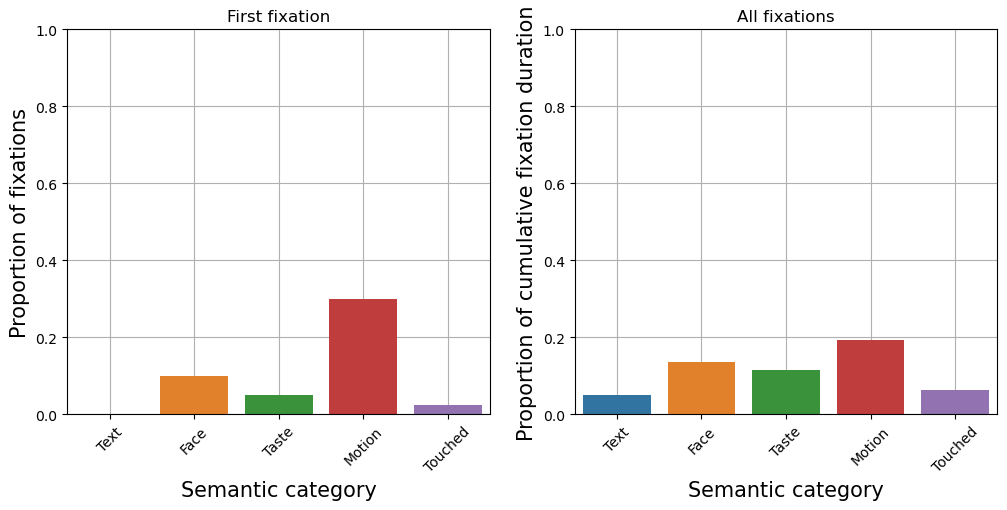

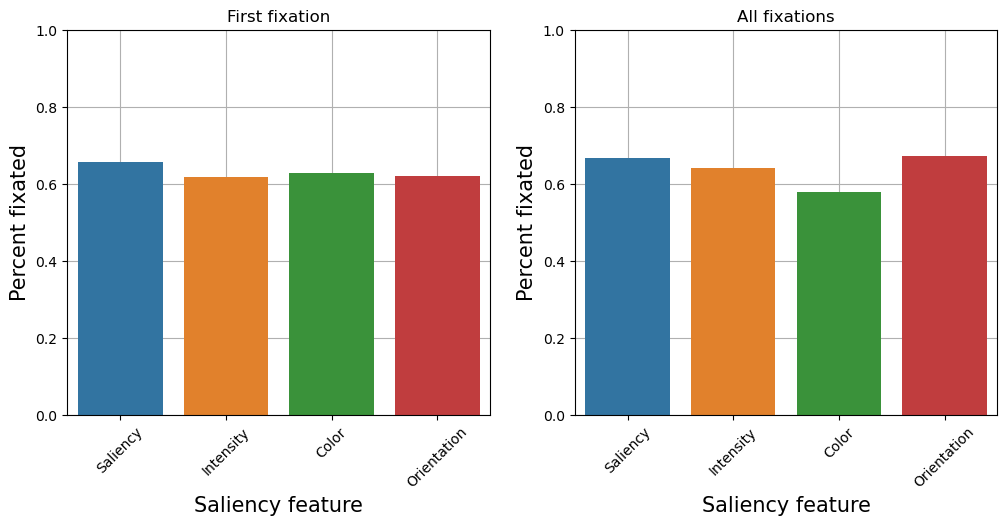

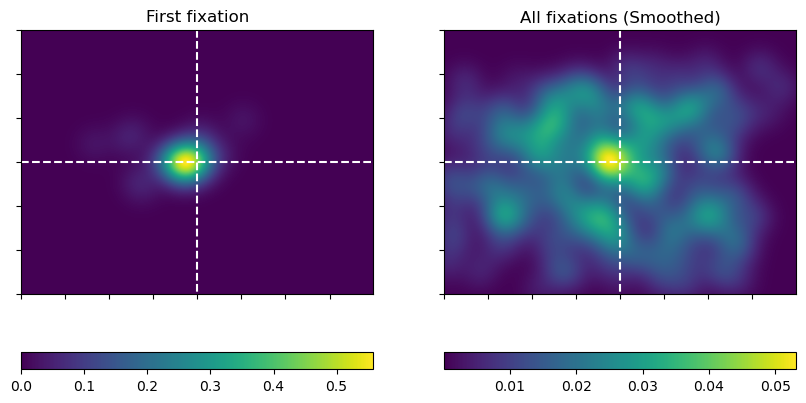

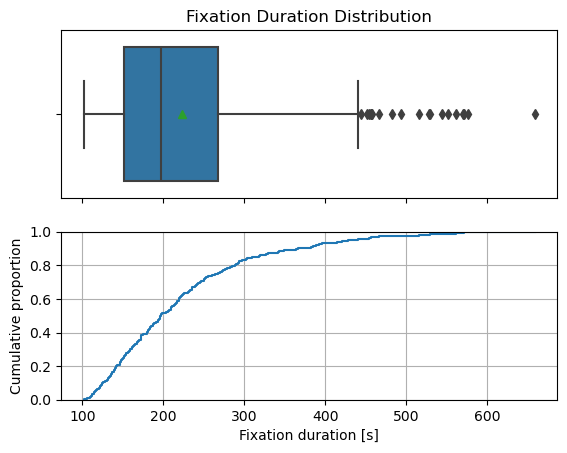

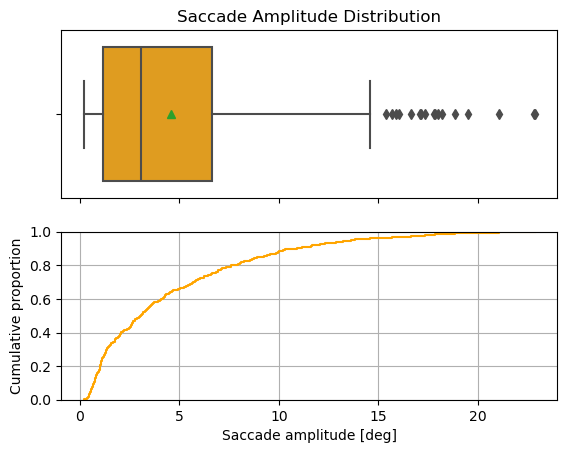

In [15]:
MY_SUBJECT_NUMBER = 'pp'

plot_fixations_semantic(MY_SUBJECT_NUMBER)
plot_fixations_salience(MY_SUBJECT_NUMBER)
plot_heatmap(MY_SUBJECT_NUMBER)
plot_eye_movement_distributions(MY_SUBJECT_NUMBER)